In [1]:
#==================================================================
#Program: SR-Preprocessing
#Version: 0.1
#Author: David Helminiak
#Date Created: March 2019
#Date Last Modified: March 2019
#Changelog: 0.1 - Data import      - March 2019
#           0.2 - Initial plots    - March 2019
#           0.3 - Comp/Pixel plots - April 2019
#           0.3 - SR plots         - April 2019
#==================================================================
#==================================================================

#==================================================================
#NOTES
#==================================================================
#pip3 install opencv-python opencv-contrib-python
#==================================================================
#==================================================================

#==================================================================
#LIBRARY IMPORTS
#==================================================================
import cv2 
import os
import math
import shutil
import sys
import matplotlib.colorbar as cbar  
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL
from IPython.display import Image
from joblib import Parallel, delayed
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from PIL import ImageOps
from scipy import stats
from sklearn.utils import shuffle



In [2]:
#==================================================================
#CLASS AND FUNCTION DEFINITIONS
#==================================================================

#Object to hold singular pixel information
class pixel:
    def __init__(self, voxel, x, y, dominantCellType, sampleID, razorProtein, sampleData):
        self.voxel = voxel
        self.x = x
        self.y = y
        self.dominantCellType = dominantCellType
        self.sampleID = sampleID
        self.razorProtein = razorProtein
        self.sampleData = sampleData
        self.image = None
        self.proteinNormalizedValues = [] #Normalized values for all of the razorProteins

def plotProteins(pixels, proteinIndexes, underImage, razorProtein, proteins, maxX, maxY, resultImageFolderPath):
    
    #Setup plot characteristics
    font = {'size' : 20}
    plt.rc('font', **font)
    cmap = plt.cm.get_cmap(cmapGR)

    fig, ax = plt.subplots(1,len(proteinIndexes), figsize=(20, 8))
    np.vectorize(lambda ax:ax.axis('off'))(ax) #Turn off axis generation for all subplots

    fig.subplots_adjust(wspace= -0.2)

    for i in range(0, len(proteinIndexes)):
        proteinIndex = proteinIndexes[i]
        ax[i] = fig.add_subplot(1,len(proteinIndexes),i+1)
        ax[i].set_title(proteins[i])
        ax[i].axis('off') #Disable axes for individual subplots

        #Obtain protein values for normalization and max x and y pixel positions
        values = []
        for pixelObject in pixels:
            values.append(pixelObject.sampleData[proteinIndex])

        if (maxY > maxX):
            scaleFactor = yLen/(2+maxY)
            xShift = xLen/math.pow(maxX,2)
            yShift = 0
        else: #maxX > maxY; Theoretically then...
            scaleFactor = xLen/(2+maxX)
            yShift = xLen/math.pow(maxX,2)
            xShift = 0

        im = ax[i].imshow(underImage)
        patchList = []
        for pixelObject in pixels: 
            #Normalize value and extract appropriate cmap coloring
            faceColorValue = cmap((pixelObject.sampleData[proteinIndex] - min(values))/(max(values)-min(values)))
            rect = patches.Rectangle([pixelObject.x*scaleFactor-xShift, pixelObject.y*scaleFactor-yShift], 1*scaleFactor, 1*scaleFactor, edgecolor='black', facecolor=faceColorValue, alpha=alphaValue)
            patchList.append(rect)

        for patch in patchList:
            ax[i].add_patch(patch)

    #Create a placeholder axes set for the colorbar
    ax = fig.add_axes([0.03, 0.2, 1, 0.5])
    img = plt.imshow(np.array([[0,100]]), cmap=cmapGR)
    img.set_visible(False)
    ax.axis('off')
    cbar = plt.colorbar(orientation="vertical", ticks=[0,100], aspect=5)
    cbar.ax.set_yticklabels(['0%','100%'])
    cbar.set_label('Relative\n Expression\n Level\n', labelpad=-100, y=1.3, rotation=0)
    
    #Save plot
    plt.savefig(resultImageFolderPath+sample+proteinStr+'_Original.png')
    
    del ax
    
#Given a set of pixels, crop and store them with their relevent data
def cropPixels(pixels, pixelFolderPath, sample, cropUnderImage, maxX, maxY, xShift, yShift):

    #Note: The y axis is reversed for pixel location selection and must be flipped before saving
    for pixelObject in pixels: 
        xPos = pixelObject.x
        yPos = pixelObject.y
        x = (xShift*(xPos-1))
        y = (yShift*(yPos-1))
        endX = x + xShift
        endY = y + yShift
        pixelObject.image = cropUnderImage.crop((x, y, endX, endY)).transpose(Image.FLIP_TOP_BOTTOM)
        pixelObject.image.save(pixelFolderPath + "sample_" + sample + "_x_" + str(xPos) + "_y_" + str(yPos) + ".png", "PNG")
    return pixels #Return the modified set of pixels 

def compositeImage(pixels, sample, maxX, maxY, xShift, yShift, resultImageFolderPath):
    compImage = Image.new('RGB', (maxX*xShift, maxY*yShift))
    pixelCounter = 0
    for i in range(0, maxY):
        for j in range(0, maxX):
            compImage.paste(im=pixels[pixelCounter].image.transpose(Image.FLIP_TOP_BOTTOM), box=(xShift*j, yShift*i))
            pixelCounter += 1
    compImage = compImage.transpose(Image.FLIP_TOP_BOTTOM)
    compImage.save(resultImageFolderPath + sample + "_compositeOpticalImage" + ".png", "PNG")
    return compImage

def proteinPlots(pixels, compImage, proteinIndex, sample, maxX, maxY, xShift, yShift, cmap, resultImageFolderPath, proteinIndividualPixelFilePaths):
    proteinCompImages = []
    for k in range(0, len(proteinIndexes)):
        proteinIndex = proteinIndexes[k]

        compImage = Image.new('RGB', (maxX*xShift, maxY*yShift))
        pixelCounter = 0
        for i in range(0, maxY):
            for j in range(0, maxX):
                xPos = pixels[pixelCounter].x
                yPos = pixels[pixelCounter].y
                mapped = np.array(cmap(pixels[pixelCounter].proteinNormalizedValues[proteinIndex]))*(255,255,255,255)
                pixelImage = Image.new('RGB', (xShift, yShift), tuple(mapped.astype(int)))
                pixelImage.save(proteinIndividualPixelFilePaths[k] + sample + "_x_" + str(xPos) + "_y_" + str(yPos) + ".png", "PNG")
                compImage.paste(im=pixelImage, box=(xShift*j, yShift*i))
                pixelCounter += 1
        compImage = compImage.transpose(Image.FLIP_TOP_BOTTOM)
        compImage.save(resultImageFolderPath + sample + "_compositeProtein_Opaque_" + proteins[k] + ".png", "PNG")
        
        cropUnderImage
        
        proteinCompImages.append(compImage)
    return proteinCompImages

def dominantTissuePlot(pixels, sample, maxX, xShift, maxY, yShift, cmapCellTypes, cellTypes, cellTypeColors, resultImageFolderPath, cellTypeIndividualPixelFilePaths):
    cellTypeCompImage = Image.new('RGB', (maxX*xShift, maxY*yShift))
    pixelCounter = 0
    for i in range(0, maxY):
        for j in range(0, maxX):
            xPos = pixels[pixelCounter].x
            yPos = pixels[pixelCounter].y

            #Determine mapped color for the cell type
            foundColor = False
            for k in range(0,len(cellTypes)):
                if (cellTypes[k] == pixels[pixelCounter].dominantCellType):
                    mapped=np.array(cmapCellTypes(int(cellTypeColors[k])))*255
                    foundColor = True
                    break
            if not foundColor:
                sys.exit("Error - The dominant cell type for a given pixel was not found in the determined cellTypes list")

            pixelImage = Image.new('RGB', (xShift, yShift), tuple(mapped.astype(int)))
            pixelImage.save(cellTypeIndividualPixelFilePaths + sample + "_x_" + str(xPos) + "_y_" + str(yPos) + ".png", "PNG")
            cellTypeCompImage.paste(im=pixelImage, box=(xShift*j, yShift*i))
            pixelCounter += 1
    cellTypeCompImage = cellTypeCompImage.transpose(Image.FLIP_TOP_BOTTOM)
    cellTypeCompImage.save(resultImageFolderPath + sample + "_compositeCellType_Opaque" + ".png", "PNG")

    #Overlay version
    foreground = cellTypeCompImage
    foreground.putalpha(int(alphaValue*256))
    background = Image.new("RGBA", compImage.size)
    background.paste(compImage)
    combinedCellTypeCompImage = Image.alpha_composite(background,foreground)
    combinedCellTypeCompImage.save(resultImageFolderPath + sample + "_compositeCellType_Opaque_Overlayed.png", "PNG")
    
    return cellTypeCompImage, combinedCellTypeCompImage

def guidedSR(guideImage, appImage, eps, radius):
    
    #Mak¥ue sure images are in the correct format; no alpha
    guideImage1 = Image.new("RGB", guideImage.size)
    guideImage1.paste(guideImage)
    guideImage = guideImage1
    appImage1 = Image.new("RGB", appImage.size)
    appImage1.paste(appImage)
    appImage = appImage1
    
    #Convert images from PIL RGB to openCV BGR
    guide = np.array(guideImage)[:, :, ::-1].copy() 
    appImage = np.array(appImage)[:, :, ::-1].copy() 

    #Perform the guided filtration 
    result = cv2.ximgproc.guidedFilter(guide,appImage, radius=int(radius),eps=eps)

    #Convert back to PIL image
    PILImage = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    PILImage = Image.fromarray(PILImage)
    return PILImage

def guidedProteinSR(proteinCompImages, compImage, proteins, eps, radius):
    proteinCompImagesSR = []
    combinedSRProteinImages = []
    for i in range(0,len(proteins)):
        SRProteinImage = guidedSR(compImage, proteinCompImages[i], eps, radius)
        proteinCompImagesSR.append(SRProteinImage)

        foreground = proteinCompImagesSR[i]
        foreground.putalpha(int(alphaValue*256))
        background = Image.new("RGBA", compImage.size)
        background.paste(compImage)
        combinedSRProteinImage = Image.alpha_composite(background,foreground)
        combinedSRProteinImages.append(combinedSRProteinImage)
    return proteinCompImagesSR, combinedSRProteinImages
        
def plotSRProteins(combinedSRProteinImages, sample, proteinIndexes, proteinStr, resultImageFolderPath):
    
    #Setup plot characteristics
    font = {'size' : 20}
    plt.rc('font', **font)
    cmap = plt.cm.get_cmap(cmapGR)

    fig, ax = plt.subplots(1,len(proteinIndexes), figsize=(20, 8))
    np.vectorize(lambda ax:ax.axis('off'))(ax) #Turn off axis generation for all subplots

    fig.subplots_adjust(wspace= -0.2)

    for i in range(0, len(proteinIndexes)):

        proteinIndex = proteinIndexes[i]
        ax[i] = fig.add_subplot(1,len(proteinIndexes),i+1)
        ax[i].set_title(proteins[i])
        ax[i].axis('off')
        im = ax[i].imshow(combinedSRProteinImages[i])

    #Create a placeholder axes set for the colorbar
    ax = fig.add_axes([0.03, 0.2, 1, 0.5])
    img = plt.imshow(np.array([[0,100]]), cmap=cmapGR)
    img.set_visible(False)
    ax.axis('off')
    cbar = plt.colorbar(orientation="vertical", ticks=[0,100], aspect=5)
    cbar.ax.set_yticklabels(['0%','100%'])
    cbar.set_label('Relative\n Expression\n Level\n', labelpad=-100, y=1.3, rotation=0)

    plt.savefig(resultImageFolderPath + sample + proteinStr + '_SR.png')

    del ax

def plotCellTypeSR(combinedSRCellTypeImage, cellTypes, cmapCellTypes, sample, resultImageFolderPath):
    legendElements = []
    for i in range(0,len(cellTypes)):
        faceColor = cmapCellTypes(int(cellTypeColors[i]))
        legendElements.append(patches.Patch(facecolor=faceColor, label=cellTypes[i]))
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.legend(handles=legendElements, loc='center left',bbox_to_anchor=(1, 0.5))
    ax.axis('off')
    plt.imshow(combinedSRCellTypeImage)
    plt.savefig(resultImageFolderPath+sample+'_compositeCellTypePlot_SR_Overlayed.png')

#Original
def plotCellType(combinedCellTypeCompImage, cellTypes, cmapCellTypes, sample, resultImageFolderPath):
    legendElements = []
    for i in range(0,len(cellTypes)):
        faceColor = cmapCellTypes(int(cellTypeColors[i]))
        legendElements.append(patches.Patch(facecolor=faceColor, label=cellTypes[i]))
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.legend(handles=legendElements, loc='center left',bbox_to_anchor=(1, 0.5))
    ax.axis('off')
    plt.imshow(combinedCellTypeCompImage)
    plt.savefig(resultImageFolderPath+sample+'_compositeCellTypePlot_Overlayed.png')


    
    
    
    
    

In [3]:
#==================================================================
#CONFIGURATION
#==================================================================

#DYNAMIC VARAIBLES
#==================================================================
sample ='LCM3' #Specify the sample to be examined
proteins = ['RTN4', 'CTNB1', 'ANXA1'] #Specify the proteins of interest for subplots

#STATIC VARAIBLES
#==================================================================
if (sample == 'LCM3'):
    xShift = 440 #Width of each pixel
    yShift = 440 #Height of each pixel
    symmetricLRSides = 303 #Number of pixels on left/right sides of grid
    USide = 453 #Number of pixels above grid
    LSide = 454 #Number of pixels below grid
elif (sample == 'LCM4'):
    xShift = 442 #Width of each pixel
    yShift = 439 #Height of each pixel
    symmetricLRSides = 298 #Number of pixels on left/right sides of grid
    USide = 455 #Number of pixels above grid
    LSide = 464 #Number of pixels below grid
else:
    sys.exit("Error: Input image parameters for sample: " + sample + " are not specified.")


#Determine smoothing level and smoothing radius for guided filtration
eps = math.pow((1e-2 * 255),2)
radius = math.sqrt(math.pow(xShift/2,2)+math.pow(yShift/2,2))


alphaValue = 0.6 #Alpha level for plot overlay
sampleFile = sample + '_SampleInfo.csv'
dataFile = sample + '_MaxQuant_Protein_Normalized_Data.csv'

#Define a green to red linear cmap 
cmapGR = LinearSegmentedColormap('GR',
    {   'red':  ((0.0, 0.0, 0.0),
                (0.5, 1.0, 1.0),
                (1.0, 1.0, 1.0)),
        'green':((0.0, 1.0, 1.0),
                (0.5, 1.0, 1.0),
                ( 1.0, 0.0, 0.0)),
        'blue': ((0.0, 0.0, 0.0),
                (0.5, 1.0, 1.0),
                (1.0, 0.0, 0.0))},)        
cmap = plt.cm.get_cmap(cmapGR)

#DATA IMPORT
#==================================================================
sampleInfo = pd.read_csv(sampleFile, na_values='?')
sampleData = pd.read_csv(dataFile, na_values='?')
underImage = Image.open('action1_' + sample+ '_noGrid.jpg').convert('L') #Read in the underlying image as grayscale
xLen, yLen = underImage.size #Obtain the underlying image dimensions

voxel = np.array(sampleInfo['Voxel'])
x = np.array(sampleInfo['X_axis'])
y = np.array(sampleInfo['Y_axis'])
sampleID = np.array(sampleInfo['SampleID'])
dominantCellType = np.array(sampleInfo['DominantCellType'])
razorProtein = np.array(sampleData['RazorProtein'])
sampleData = sampleData.drop(['RazorProtein'], axis=1) #Remove the razor protein list from the data object; causes issues during extraction

#Store pixel information
pixels = [] #Array holding all of the recorded pixel information
maxX = 1 #Maximum starting x pixel index
maxY = 1 #Maximum starting y pixel index
for i in range(0, len(sampleID)):
    pixels.append(pixel(voxel[i], x[i], y[i], dominantCellType[i], sampleID[i], razorProtein, np.array(sampleData[sampleID[i]])))
    if (x[i] > maxX): 
        maxX = x[i]
    if (y[i]> maxY): 
        maxY = y[i]

#Organize the pixels from left to right, bottom to top
orderedPixels = []
for i in range(1, maxY+1):
    for j in range(1, maxX+1):
        for k in range(0, len(pixels)):
            if (pixels[k].y == i and pixels[k].x == j):
                orderedPixels.append(pixels[k])
pixels = orderedPixels
del orderedPixels


#Find index of the protein within the razorProtein list
proteinIndexes = [] #Index list for each of the proteins of interest specified
proteinStr = '' #String to hold the proteinID for output filename
for i in range(0, len(proteins)):
    protein = proteins[i]
    proteinStr = proteinStr + '_' + proteins[i]
    proteinIndex = -1
    for i in range(0, len(razorProtein)):
        if (protein in razorProtein[i]):
            proteinIndex = i
    if (proteinIndex == -1):
        sys.exit('Error! - A specified protein: ' + protein + ' was not found.')
    else:
        proteinIndexes.append(proteinIndex)
if (len(proteinIndexes) != len(proteins)):
    sys.exit('Error! - Certain proteins were found more than once')   

#Obtain normalization values for all of the proteins for each of the sample's pixels
for proteinIndex in range(0,len(razorProtein)):
    #Obtain all values for normalization
    values = []
    for pixelObject in pixels:
        values.append(pixelObject.sampleData[proteinIndex])
    
    #Add each pixel's normalized value for that protein
    for pixelObject in pixels: 
        pixelObject.proteinNormalizedValues.append((pixelObject.sampleData[proteinIndex] - min(values))/(max(values)-min(values)))

#Obtain list of cell types and assign each a different value for finding a unique cmap(color) value
cellTypes = []
for i in range (0, len(pixels)):
    foundType = False
    for j in range(0, len(cellTypes)):
        if pixels[i].dominantCellType == cellTypes[j]:
            foundType = True
    if not foundType:
        cellTypes.append(pixels[i].dominantCellType)
        
cellTypes.sort()

cmapCellTypes = plt.cm.jet
cmapCellTypeList = [cmapCellTypes(i) for i in range(cmap.N)]
cmapCellTypeList[0] = (.5, .5, .5, 1.0)
cmapCellTypes = mpl.colors.LinearSegmentedColormap.from_list('cellTypes', cmapCellTypeList, cmap.N)
        
colorDelta = 255/len(cellTypes) #Calculate maximal color delta along cmap
cellTypeColors = []
for i in range (0, len(cellTypes)):
    cellTypeColors.append(i*colorDelta)


#Create a save location for all images produced for all sample results
resultFolderPath = '.' + os.path.sep + str(sample) + '_Results' + os.path.sep

#Create a save location for all images produced for a sample
resultImageFolderPath = resultFolderPath + 'Images' + os.path.sep

#Create a save location for all of the individual pixel images in the sample specified
pixelFolderPath = resultFolderPath + 'IndividualOpticalPixels' + os.path.sep

#Create a save location for all of the specified proteins individual pixel images in the sample specified
proteinPixelFolderPath = resultFolderPath + 'IndividualProteinPixels' + os.path.sep

#Create a save location for all of the dominant cell type pixels
cellTypeIndividualPixelFilePaths = resultFolderPath + 'IndividualCellTypePixels' + os.path.sep

#Create a save location for animations
resultAnimationFolderPath = resultFolderPath + 'Animations' + os.path.sep

#Create a save location for cell type mask thresholding animation
resultThresholdMaskAnimationFolderPath = resultAnimationFolderPath + 'CellTypeMask_SR_Thresholding' + os.path.sep

#Create a save location for protein SR thresholding animation 
resultThresholdProteinSRAnimationFolderPath = resultAnimationFolderPath + 'Protein_SR_Thresholding' + os.path.sep

#Create base paths
if os.path.exists(resultFolderPath):
    shutil.rmtree(resultFolderPath)
os.makedirs(resultFolderPath)
os.makedirs(resultImageFolderPath)
os.makedirs(pixelFolderPath)
os.makedirs(proteinPixelFolderPath)
os.makedirs(cellTypeIndividualPixelFilePaths)
os.makedirs(resultAnimationFolderPath)
os.makedirs(resultThresholdMaskAnimationFolderPath)
os.makedirs(resultThresholdProteinSRAnimationFolderPath)

#Create dynamic sub-paths
proteinIndividualPixelFilePaths = []
for i in range(0, len(proteins)):
    proteinIndividualPixelFilePath = proteinPixelFolderPath + proteins[i] + os.path.sep
    proteinIndividualPixelFilePaths.append(proteinIndividualPixelFilePath)
    os.makedirs(proteinIndividualPixelFilePath)
        

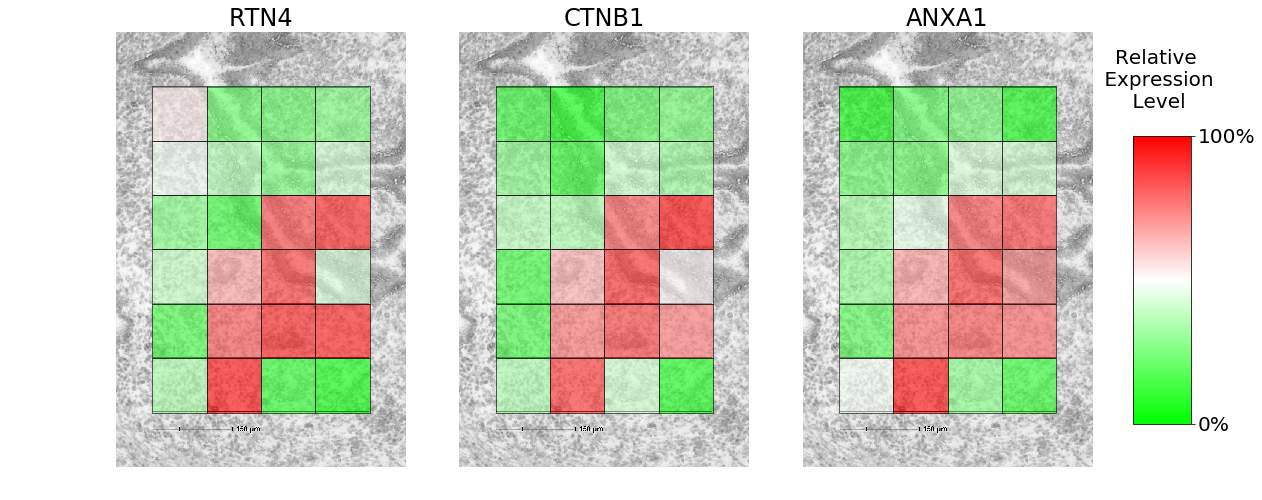

In [4]:
#MAIN PROGRAM
#==================================================================

#Plot initial expression levels for proteins specified
plotProteins(pixels, proteinIndexes, underImage, razorProtein, proteins, maxX, maxY, resultImageFolderPath)

#Crop underlying optical image to the edges of the grid
lowX = symmetricLRSides
highX = 2400-symmetricLRSides
lowY = USide
highY = 3600-LSide
#Flip image upside down to set the origin in the lower left
cropUnderImage = underImage.crop((lowX, lowY, highX , highY))
cropUnderImage = cropUnderImage.transpose(Image.FLIP_TOP_BOTTOM)

#Remove the grid
a = np.asarray(cropUnderImage.convert('L'))
xShape, yShape = a.shape
delX = []
delY = []
gridThreshold = np.mean(a)-(np.std(a)/2)

for i in range(0, xShape):
    if (np.mean(a[i])) < gridThreshold:
        delX.append(i)
for i in range(0, yShape):
    if (np.mean(a[:,i])) < gridThreshold:
        delY.append(i)

b = np.delete(a, delY, axis=1)
b = np.delete(b, delX, axis=0)
cropUnderImage = Image.fromarray(b)

#Separate out individual pixels optical images
pixels = cropPixels(pixels, pixelFolderPath, sample, cropUnderImage, maxX, maxY, xShift, yShift) 

#Composite the individual pixels back together again
compImage = compositeImage(pixels, sample, maxX, maxY, xShift, yShift, resultImageFolderPath)

#Visualize relevant protein relative expression levels seperately
proteinCompImages = proteinPlots(pixels, compImage, proteinIndex, sample, maxX, maxY, xShift, yShift, cmap, resultImageFolderPath, proteinIndividualPixelFilePaths)

#Generate composite of dominant cell types by pixel
cellTypeCompImage, combinedCellTypeCompImage = dominantTissuePlot(pixels, sample, maxX, xShift, maxY, yShift, cmapCellTypes, cellTypes, cellTypeColors, resultImageFolderPath, cellTypeIndividualPixelFilePaths)

#Plot dominant cell types
plotCellType(combinedCellTypeCompImage, cellTypes, cmapCellTypes, sample, resultImageFolderPath)

#Perform a guided filtration to perform super resolution on the dominant cell type
cellTypeCompImageSR = guidedSR(compImage, cellTypeCompImage, eps, radius)
cellTypeCompImageSR.save(resultImageFolderPath + sample + "_compositeCellType_SR.png", "PNG")

#Create overlayed version of the SR cell types image 
foreground = cellTypeCompImageSR
foreground.putalpha(int(alphaValue*256))
background = Image.new("RGBA", compImage.size)
background.paste(compImage)
combinedSRCellTypeImage = Image.alpha_composite(background,foreground)
combinedSRCellTypeImage.save(resultImageFolderPath + sample + "_compositeCellType_SR_Overlayed.png", "PNG")

#Perform a guided filtration to perform super resolution on each of the specified proteins
proteinCompImagesSR, combinedSRProteinImages = guidedProteinSR(proteinCompImages, compImage, proteins, eps, radius)
for i in range(0, len(combinedSRProteinImages)):
    combinedSRProteinImages[i].save(resultImageFolderPath + sample + "_compositeProtein_SR_Overlayed_" + proteins[i] + ".png", "PNG")
    proteinCompImagesSR[i].save(resultImageFolderPath + sample + "_compositeProtein_SR_Opaque_" + proteins[i] + ".png", "PNG")

#Plot SR dominant cell types
plotCellTypeSR(combinedSRCellTypeImage, cellTypes, cmapCellTypes, sample, resultImageFolderPath)

#Plot SR expression levels for proteins specified
plotSRProteins(combinedSRProteinImages, sample, proteinIndexes, proteinStr, resultImageFolderPath)





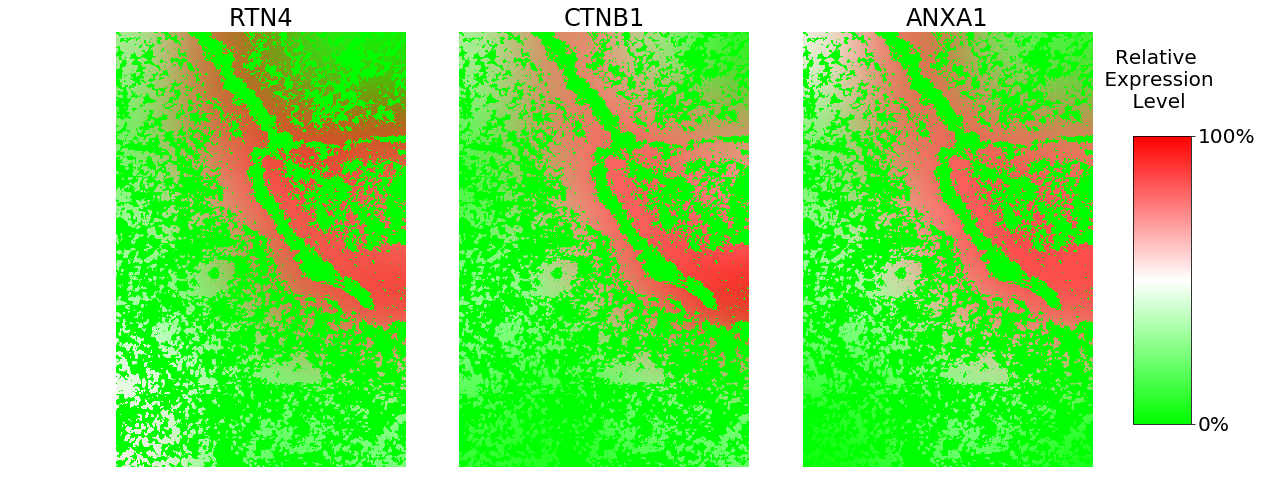

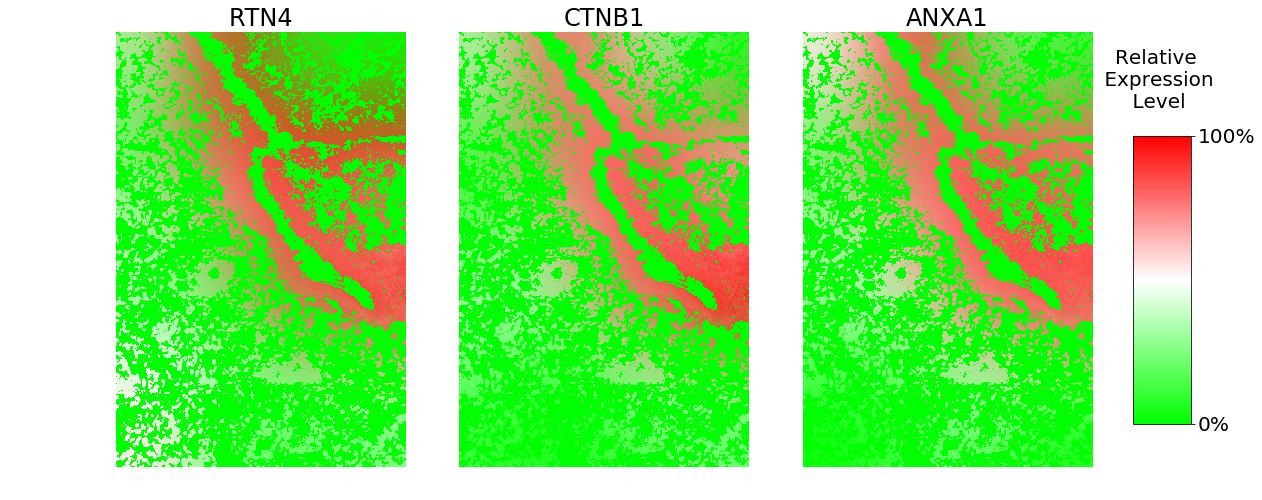

In [8]:


#=====================================================================================================================
#=====================================================================================================================

#Make an openCV image mask of the optical image thresholding it by the mean of pixel intensities
maskedCompImage = compImage.convert('L')
maskedCompImage = maskedCompImage.point(lambda x: 255 if x<np.mean(np.asarray(compImage)) else 0, '1')
maskedCompImageMask = np.asarray(maskedCompImage.convert('RGB')).copy()
maskedCompImageMask = cv2.cvtColor(maskedCompImageMask,cv2.COLOR_BGR2GRAY)

#Isolate each dominant cell type
isolatedCellCompImages = []
isolatedCellCompImagesSR = []
maskedIsolatedCellCompImagesSR = []
cellTypeSRMasks = []
for k in range(0,len(cellTypes)):
    isolatedTypeCompImage = Image.new('RGBA', (maxX*xShift, maxY*yShift), (255,255,255,0))
    pixelCounter = 0
    for i in range(0, maxY):
        for j in range(0, maxX):
            if (cellTypes[k] == pixels[pixelCounter].dominantCellType):
                pixelImage = Image.new('RGBA', (xShift, yShift), (0, 0, 0))
                isolatedTypeCompImage.paste(im=pixelImage, box=(xShift*j, yShift*i))
            pixelCounter+=1
    isolatedTypeCompImage = isolatedTypeCompImage.transpose(Image.FLIP_TOP_BOTTOM)    
    isolatedCellCompImages.append(isolatedTypeCompImage)

    #Perform guided filtration on each
    isolatedCellTypeCompImageSR = guidedSR(compImage, isolatedTypeCompImage, eps, radius)
    isolatedCellCompImagesSR.append(isolatedCellTypeCompImageSR)
    
    #Remove alpha and set to grayscale type inverting white and black; white is presence, black is absence
    masked = PIL.ImageOps.invert(isolatedCellTypeCompImageSR.convert('L'))
    
    #Threshold values to binary mask
    masked = masked.point(lambda x: 255 if x>0 else 0, '1')
    
    #Now limit the mask by the optical threshold mask such that it contains only optically visible structures 
    maskedCompImageMask = np.asarray(maskedCompImage.convert('L')).copy()
    maskedIsolatedCellCompImagesSRMask = np.asarray(masked.convert('L')).copy()
    cellTypeSRMask = cv2.bitwise_and(maskedCompImageMask, maskedIsolatedCellCompImagesSRMask)
    cellTypeSRMask = Image.fromarray(cellTypeSRMask)
    cellTypeSRMasks.append(cellTypeSRMask)

#Perform combination of masks for cell types with Epithelium
cellTypeGuideMask = Image.new('RGBA', (maxX*xShift, maxY*yShift), (0,0,0,255))
for k in range(0,len(cellTypes)):
    if 'Epithelium' in cellTypes[k]:
        cellTypeGuideMask = Image.fromarray(cv2.bitwise_or(np.asarray(cellTypeSRMasks[k].convert('RGB')).copy(), np.asarray(cellTypeGuideMask.convert('RGB')).copy()))

#Keep a BW copy of the mask
cellTypeGuideMaskBW = cellTypeGuideMask.copy()        

#Save combined mask
cellTypeGuideMask.save(resultThresholdMaskAnimationFolderPath + sample + '_Threshold_' + 'none.png', "PNG")

#Set mask color to be the same as a 0% relative expression value
cellTypeGuideMask = np.asarray(maskedCompImage.convert('RGB')).copy()
cellTypeGuideMask[np.where((cellTypeGuideMask==[0,0,0]).all(axis=2))] = (np.asarray(cmap(0))*255).astype(int).tolist()[0:3]
cellTypeGuideMask = Image.fromarray(cellTypeGuideMask).convert('RGBA')

#Convert white values to alpha
cellTypeGuideMask = np.asarray(cellTypeGuideMask.convert('RGBA')).copy()
cellTypeGuideMask[:, :, 3] = (255 * (cellTypeGuideMask[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
cellTypeGuideMask = Image.fromarray(cellTypeGuideMask)

#Perform protein SR
proteinCompImagesSR, combinedSRProteinImages = guidedProteinSR(proteinCompImages, cellTypeGuideMask, proteins, eps, radius)
maskedProteinCompImagesSR = []
for n in range(0,len(proteinCompImagesSR)):
    #Overlay the protein SR images with the combined mask expressing 0% relative expression levels
    maskedProteinCompImageSR = Image.new('RGB', (maxX*xShift, maxY*yShift), (255,255,255,255))
    maskedProteinCompImageSR = Image.alpha_composite(proteinCompImagesSR[n].convert('RGBA'), cellTypeGuideMask)
    maskedProteinCompImageSR = maskedProteinCompImageSR.convert('RGB')
    maskedProteinCompImagesSR.append(maskedProteinCompImageSR)
    maskedProteinCompImageSR.save(resultThresholdProteinSRAnimationFolderPath + sample + "_compositeProtein_SR_Opaque_" + proteins[n] + '_Threshold_none' + ".png", "PNG")

#Setup plot characteristics
font = {'size' : 20}
plt.rc('font', **font)
cmap = plt.cm.get_cmap(cmapGR)

fig, ax = plt.subplots(1,len(proteinIndexes), figsize=(20, 8))
np.vectorize(lambda ax:ax.axis('off'))(ax) #Turn off axis generation for all subplots

fig.subplots_adjust(wspace= -0.2)

for i in range(0, len(proteinIndexes)):

    proteinIndex = proteinIndexes[i]
    ax[i] = fig.add_subplot(1,len(proteinIndexes),i+1)
    ax[i].set_title(proteins[i])
    ax[i].axis('off')
    im = ax[i].imshow(maskedProteinCompImagesSR[i])

#Create a placeholder axes set for the colorbar
ax = fig.add_axes([0.03, 0.2, 1, 0.5])
img = plt.imshow(np.array([[0,100]]), cmap=cmapGR)
img.set_visible(False)
ax.axis('off')
cbar = plt.colorbar(orientation="vertical", ticks=[0,100], aspect=5)
cbar.ax.set_yticklabels(['0%','100%'])
cbar.set_label('Relative\n Expression\n Level\n', labelpad=-100, y=1.3, rotation=0)

plt.savefig(resultThresholdProteinSRAnimationFolderPath + sample + "_compositeProtein_SR_Opaque_" + proteins[n] + '_' + proteinStr + '_Threshold_' + 'none_SR.png')

del ax 




#=====================================================================================================================
#=====================================================================================================================

#Mask the original optical image by the combined mask to be used as a guide for the protein guided filtration
maskedOpticalGuide = Image.fromarray(cv2.bitwise_and(np.asarray(compImage.convert('L')),np.asarray(cellTypeGuideMaskBW.convert('L'))))
maskedOpticalGuide.save(resultThresholdMaskAnimationFolderPath + sample + '_MaskedOptical_Threshold_' + 'none.png', "PNG")

#Perform protein SR using the masked optical guide
proteinCompImagesSR, combinedSRProteinImages = guidedProteinSR(proteinCompImages, maskedOpticalGuide, proteins, eps, radius)
maskedProteinCompImagesSR = []
for n in range(0,len(proteinCompImagesSR)):
    #Overlay the protein SR images with the combined mask expressing 0% relative expression levels
    maskedProteinCompImageSR = Image.new('RGB', (maxX*xShift, maxY*yShift), (255,255,255,255))
    maskedProteinCompImageSR = Image.alpha_composite(proteinCompImagesSR[n].convert('RGBA'), cellTypeGuideMask)
    maskedProteinCompImageSR = maskedProteinCompImageSR.convert('RGB')
    maskedProteinCompImagesSR.append(maskedProteinCompImageSR)
    maskedProteinCompImageSR.save(resultThresholdProteinSRAnimationFolderPath + sample + "_compositeProtein_SR_Opaque_MaskedOptical" + proteins[n] + '_Threshold_none' + ".png", "PNG")

#Setup plot characteristics
font = {'size' : 20}
plt.rc('font', **font)
cmap = plt.cm.get_cmap(cmapGR)

fig, ax = plt.subplots(1,len(proteinIndexes), figsize=(20, 8))
np.vectorize(lambda ax:ax.axis('off'))(ax) #Turn off axis generation for all subplots

fig.subplots_adjust(wspace= -0.2)

for i in range(0, len(proteinIndexes)):

    proteinIndex = proteinIndexes[i]
    ax[i] = fig.add_subplot(1,len(proteinIndexes),i+1)
    ax[i].set_title(proteins[i])
    ax[i].axis('off')
    im = ax[i].imshow(maskedProteinCompImagesSR[i])

#Create a placeholder axes set for the colorbar
ax = fig.add_axes([0.03, 0.2, 1, 0.5])
img = plt.imshow(np.array([[0,100]]), cmap=cmapGR)
img.set_visible(False)
ax.axis('off')
cbar = plt.colorbar(orientation="vertical", ticks=[0,100], aspect=5)
cbar.ax.set_yticklabels(['0%','100%'])
cbar.set_label('Relative\n Expression\n Level\n', labelpad=-100, y=1.3, rotation=0)

plt.savefig(resultThresholdProteinSRAnimationFolderPath + sample + "_compositeProtein_SR_Opaque_MaskedOptical" + proteins[n] + '_' + proteinStr + '_Threshold_' + 'none_SR.png')

del ax 

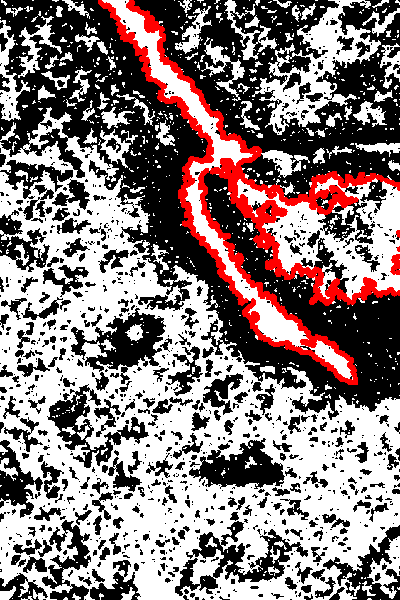

In [173]:
test = compImage.convert('L')
test = maskedCompImage.point(lambda x: 255 if x<np.mean(np.asarray(compImage)) else 0, '1')
#test = PIL.ImageOps.invert(test.convert('L'))

test = np.asarray(test.convert('RGB')).copy()
backup = test
test = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)

kernel = np.ones((1,1),np.uint8) #Set minimum filter size
img = cv2.erode(test, kernel, iterations = 1) #Filter areas based on kernel size
#img = cv2.dilate(img,kernel,iterations = 1)
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Identify areas
areas = [cv2.contourArea(c) for c in contours] #Save the areas into an object

testResult = cv2.drawContours(np.asarray(backup), contours[9285], -1, (255, 0, 0), 20) #Draw all areas in red into the color image
Image.fromarray(testResult).resize([400,600])





In [131]:
areas.sort()

In [171]:

idx = np.argsort(areas)[-10:]
idx

array([7312, 8508, 9897, 5335, 3072, 4547, 6185, 8903, 9285, 2281])

In [175]:
(img.shape[0]*img.shape[1])/10

464640.0

In [174]:
areas[8903]

117281.0

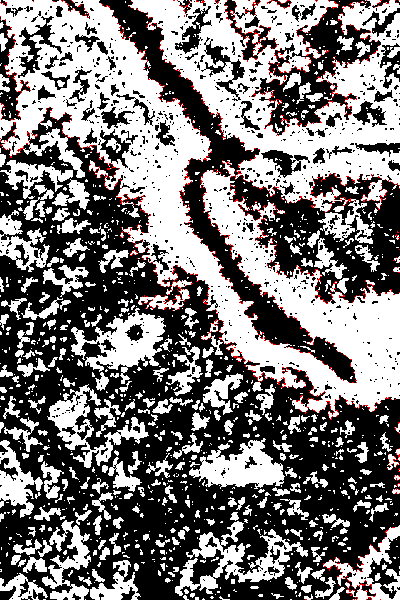

In [92]:
testResult = cv2.drawContours(np.asarray(backup), contours[np.argmax(areas)], -1, (255, 0, 0), 2) #Draw all areas in red into the color image
Image.fromarray(testResult).resize([400,600])





In [80]:
len(areas)

10380